# Seasonal Autoregressive Integrated Moving Average with Exogenous Regressors
### Model for time series forecasting with data containing trends and/or seasonality _and_ exogenous variables
#### Google Flu Trends emulation (Google search terms include multiple flu-related symptoms)

In [186]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.set_option('display.max_rows', 10)

In [187]:
df_hospital = pd.read_csv('../data/hospital_visits.csv')
df_hospital['Week'] = df_hospital.Week.map(str) + "-" + df_hospital.Year.map(str)
df_hospital = df_hospital[['Week', 'Total ILI']]
df_hospital.columns = ['Week', 'ILI']
df_hospital = df_hospital[28:256]
df_hospital = df_hospital.reset_index(drop=True)

df_twitter = pd.read_csv('../data/twitter-flu-data.csv', header=None)
df_twitter.columns = ['Year', 'Week', '1', '2', '3', '4', '5', '6', '7']
df_twitter['Week'] = df_twitter.Week.map(str) + "-" + df_twitter.Year.map(str)
df_twitter['Tweets'] = df_twitter[['1', '2', '3', '4', '5', '6', '7']].sum(axis=1)
df_twitter = df_twitter[['Week', 'Tweets']][27:-1]
df_twitter = df_twitter.reset_index(drop=True)

df_aus = pd.read_csv('../data/AUS_flu_virus_counts.csv')
df_aus['Week'] = df_aus.Week.map(str) + "-" + df_aus.Year.map(str)
df_aus = df_aus[['Week', 'ALL_INF']]
df_aus = df_aus[912:1168-27]
df_aus = df_aus.drop(977)
df_aus = df_aus.reset_index(drop=True)

df_google = pd.read_csv('../data/google_trends/all_google_trends.csv')
df_google['Week'] = df_google.Week.map(str) + "-" + df_google.Year.map(str)
df_google = df_google[['Week', 'fever', 'cough', 'flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'headache', 'sore throat', 'cold flu', 'cold', 'flu virus', 'stomach flu']]
df_google = df_google[17:246]
df_google = df_google.drop(159)
df_google = df_google.reset_index(drop=True)

In [188]:
list_hospital = list(df_hospital['ILI'])
list_tweets = list(df_twitter['Tweets'])
list_aus = list(df_aus['ALL_INF'])
list_google = df_google[['fever', 'cough', 'flu season', 'flu shot', 'flu symptoms', 'flu', 'flu vaccine', 'flu vs cold', 'headache', 'sore throat', 'cold flu', 'cold', 'flu virus', 'stomach flu']].values.tolist()

In [156]:
list_hospital_real = list_hospital[:-52]
list_tweets_real = list_tweets[:-52]
list_aus_real = list_aus[:-52]
list_google_real = list_google[:-52]

list_hospital_pred = list_hospital[-52:]
list_tweets_pred = list_tweets[-52:]
list_aus_pred = list_aus[-52:]
list_google_pred = list_google[-52:]

In [157]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].extend(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].extend(list_google_pred[pred_index])

google_transposed = list(map(list, zip(*list_google)))
to_plot_transposed = [list_tweets, list_aus]
to_plot_transposed.extend(google_transposed)

In [166]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [167]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real), len(list_hospital_real) + future))

In [168]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

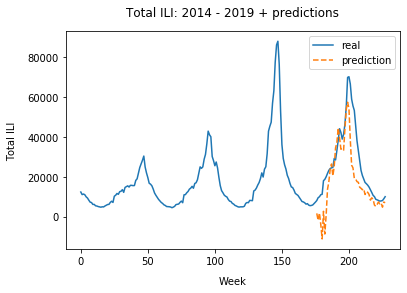

In [169]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

Text(0.5, 1.0, 'Model features (all Google search terms + tweets + AUS virus counts)')

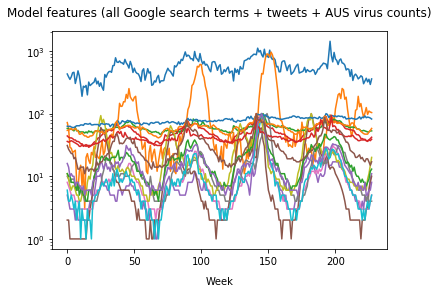

In [212]:
for i in to_plot_transposed:
    plt.plot(i)
plt.yscale('log')
plt.xlabel("Week", labelpad=10)
# plt.ylabel("", labelpad=10)
plt.title("Model features (all Google search terms + tweets + AUS virus counts)", pad=15)

In [164]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -634.026
Date:                            Tue, 10 Dec 2019   AIC                           1306.052
Time:                                    20:09:59   BIC                           1349.043
Sample:                                         0   HQIC                          1323.148
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -18.3279    358.724     -0.051      0.959    -721.414     684.758
x1           -10.5626      4.997     -2.114      0.035     -20.357      -0.768
x2             5.1480      7.146      0.720      0.471      -8.858      19.154
x3           100.7526     78.875      1.277      0.201     -53.839     255.344
x4            56.6959    239.740      0.236      0.813    -413.187     526.578
x5            15.4355    190.439      0.081      0.935    -357.818     388.689
x6          -483.3327    227.469     -2.125      0.034    -929.163     -37.502
x7           512.1315    184.258      2.779      0.005     150.993     873.270
x8           143.1413     63.218      2.264      0.024      19.236     267.047
x9          -182.2524    118.155     -1.542      0.123    -413.833      49.328
x10          -40.4822    135.468     -0.299      0.765    -305.994     225.030
x11           86.2019     90.880      0.949      0.343     -91.920     264.324
x12          -75.9445    100.813     -0.753      0.451    -273.534     121.645
x13          116.3316    168.674      0.690      0.490    -214.264     446.927
x14          -25.7020     57.678     -0.446      0.656    -138.749      87.345
x15          240.7508    116.475      2.067      0.039      12.465     469.037
x16          -82.1177     84.724     -0.969      0.332    -248.174      83.939
ar.S.L52       0.4055      0.225      1.799      0.072      -0.036       0.847
sigma2      3.503e+06   9.21e+05      3.802      0.000     1.7e+06    5.31e+06
===================================================================================
Ljung-Box (Q):                       42.96   Jarque-Bera (JB):               193.49
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -1.90
Prob(H) (two-sided):                  0.40   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicting a previous year

In [189]:
list_hospital_real = list_hospital[:-104]
list_tweets_real = list_tweets[:-104]
list_aus_real = list_aus[:-104]
list_google_real = list_google[:-104]

list_hospital_pred = list_hospital[-104:-52]
list_tweets_pred = list_tweets[-104:-52]
list_aus_pred = list_aus[-104:-52]
list_google_pred = list_google[-104:-52]

# Comment out these lines to only train on the data before where predictions will take place
list_hospital_real.extend(list_hospital[-52:])
list_tweets_real.extend(list_tweets[-52:])
list_aus_real.extend(list_aus[-52:])
list_google_real.extend(list_google[-52:])

In [190]:
features_transposed = [list_tweets_real, list_aus_real]
pred_transposed = [list_tweets_pred, list_aus_pred]

features = list(map(list, zip(*features_transposed)))
pred = list(map(list, zip(*pred_transposed)))

for feature_index in range(len(features)):
    features[feature_index].extend(list_google_real[feature_index])

for pred_index in range(len(pred)):
    pred[pred_index].extend(list_google_pred[pred_index])

In [191]:
model = SARIMAX(endog=list_hospital_real, exog=features, order=(1, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False, trend='c')
model_fit = model.fit()

C:\Users\steph\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [196]:
future = 52
predictions = model_fit.predict(len(list_hospital_real), len(list_hospital_real) + future - 1, exog=pred)
future_weeks = list(range(len(list_hospital_real) - future, len(list_hospital_real)))

In [197]:
predictions_df = pd.DataFrame([future_weeks, predictions]).transpose()
predictions_df.columns = ['Week', 'Total ILI']
predictions_df = predictions_df.set_index('Week')

Text(0.5, 1.0, 'Total ILI: 2014 - 2019 + predictions')

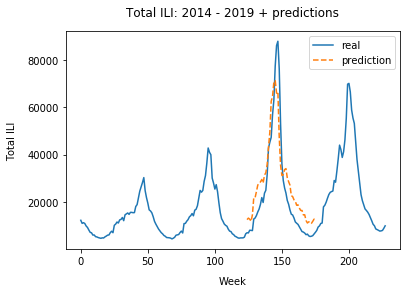

In [198]:
plt.plot(df_hospital['ILI'], label='real')
plt.plot(predictions_df, '--', label='prediction')
plt.legend()
plt.xlabel("Week", labelpad=10)
plt.ylabel("Total ILI", labelpad=10)
plt.title("Total ILI: 2014 - 2019 + predictions", pad=15)

In [199]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -617.698
Date:                            Tue, 10 Dec 2019   AIC                           1275.396
Time:                                    21:47:07   BIC                           1320.365
Sample:                                         0   HQIC                          1293.258
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -12.8373    328.165     -0.039      0.969    -656.029     630.354
x1            -0.0636      4.187     -0.015      0.988      -8.269       8.142
x2           -18.4386      8.116     -2.272      0.023     -34.345      -2.532
x3           152.1506    120.552      1.262      0.207     -84.126     388.428
x4            -0.8826    176.941     -0.005      0.996    -347.680     345.915
x5           174.7709    266.246      0.656      0.512    -347.061     696.603
x6          -108.9520    137.844     -0.790      0.429    -379.122     161.218
x7           353.6210    266.463      1.327      0.184    -168.637     875.879
x8          -273.0487    184.256     -1.482      0.138    -634.184      88.087
x9            79.4213    104.768      0.758      0.448    -125.921     284.763
x10          -86.8031    157.808     -0.550      0.582    -396.100     222.494
x11          -49.8760    107.374     -0.465      0.642    -260.325     160.573
x12          -91.8046    175.434     -0.523      0.601    -435.649     252.040
x13          -55.4868    232.648     -0.239      0.811    -511.468     400.495
x14           -2.1861     44.532     -0.049      0.961     -89.467      85.094
x15           -3.5920    163.277     -0.022      0.982    -323.610     316.426
x16           35.9646     93.183      0.386      0.700    -146.670     218.599
ar.L1          0.2707      0.277      0.976      0.329      -0.273       0.815
ar.S.L52      -0.1174      0.199     -0.590      0.555      -0.507       0.273
sigma2      2.811e+06   5.39e+05      5.213      0.000    1.75e+06    3.87e+06
===================================================================================
Ljung-Box (Q):                       27.36   Jarque-Bera (JB):                41.03
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.64
Prob(H) (two-sided):                  0.51   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""